# Learning pendulum inverse dynamics

In [1]:
import os
import pandas as pd
import numpy as np
import torch

from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import sys

sys.path.append("../..")

from src.physics_dataset import PhysicsStatesDataset
from src.ai_models import FullyConnectedCtrl, CasadiModel

In [2]:
dataset = PhysicsStatesDataset("../../data/interim/pendulum/mixed1.csv")

In [3]:
dataset.dataframe.head()

,id,time,qpos,qvel,qacc,ctrl
0,0,0.001,[-5.27405987e-05],[-0.0527406],[-52.74059872],[-57.4872526]
1,1,0.002,[-0.00013264],[-0.07989561],[-27.15500922],[-29.59911526]
2,2,0.003,[-0.00021852],[-0.08588338],[-5.9877766],[-6.52706684]
3,3,0.004,[-0.00031071],[-0.09218989],[-6.30650874],[-6.87473762]
4,4,0.005,[-0.00044756],[-0.13684961],[-44.65972047],[-48.68000974]


In [4]:
from sklearn.model_selection import train_test_split

proportion = 0.2
x_train, x_test, y_train, y_test = train_test_split(
    dataset.states, dataset.ctrls, test_size=proportion, random_state=42
)

In [5]:
train_loader = DataLoader(
    TensorDataset(torch.tensor(x_train), torch.tensor(y_train)),
    batch_size=20,
    shuffle=True,
)
val_loader = DataLoader(
    TensorDataset(torch.tensor(x_test), torch.tensor(y_test)),
    batch_size=20,
    shuffle=True,
)

/tmp/ipykernel_229699/3394741560.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  TensorDataset(torch.tensor(x_train), torch.tensor(y_train)),
/tmp/ipykernel_229699/3394741560.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  TensorDataset(torch.tensor(x_test), torch.tensor(y_test)),


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = FullyConnectedCtrl(
    nv=1,
    ctrl=1,
    linear_layers=3,
    linear_hidden_size=100,
).to(device)

In [7]:
model.load_state_dict(torch.load("../../data/models/pendulum_fc.pt"))

<All keys matched successfully>

In [8]:
# _, val_losses = model.train_model(
#     train_loader,
#     val_loader,
#     epochs=30,
#     ckpt_path="../../data/models/pendulum_fc.pt",
# )


In [9]:
# plt.title("Validation losses")
# plt.plot(val_losses)
# plt.grid()
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.show()

### Model is trained, now we go to inferecing and copying its weights

In [10]:
model(torch.tensor([0, 0, 0], dtype=torch.float))

tensor([-0.3516], grad_fn=<ViewBackward0>)

In [11]:
casadi_model = CasadiModel(model)

In [12]:
casadi_model(np.array([0, 0, 0]))

DM(-0.351554)

As we see, we have transfered all weights correctly

# Trajectory optimization

In [13]:
import casadi as cs

q0 = 0
qfinal = cs.pi

In [14]:
# formulate problem

opti = cs.Opti()

T = 5
N = T * 500

x = opti.variable(N, 3)
q = x[:, 0]
dq = x[:, 1]
ddq = x[:, 2]

opti.subject_to(q[0] == q0)
opti.subject_to(q[-1] == qfinal)

opti.set_initial(q, cs.linspace(q0, qfinal, N))
opti.set_initial(dq, (qfinal - q0) / T)
opti.set_initial(ddq, (qfinal - q0) / T**2)

opti.subject_to(dq[0] == 0)
opti.subject_to(dq[-1] == 0)

opti.subject_to(ddq[-1] == 0)
opti.subject_to(ddq[0] == 0)

In [15]:
casadi_model(x[0, :])

MX(inference(opti0_x_1[:7500:2500]){0})

In [16]:
# integration constraints
dt = T / N

for i in range(N - 1):
    opti.subject_to(q[i + 1] == q[i] + dt * dq[i + 1])
    opti.subject_to(dq[i + 1] == dq[i] + dt * ddq[i])

cost = 0

# dynamics constraints
for i in range(N - 1):
    u = casadi_model(x[i, :])

    # # constraint might come from our motor possibilites
    opti.subject_to(opti.bounded(-30, u, 30))

    cost += 10 * u**2

opti.minimize(cost)

In [17]:
opti.solver("ipopt")
opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    15000
Number of nonzeros in inequality constraint Jacobian.:     7497
Number of nonzeros in Lagrangian Hessian.............:    14994

Total number of variables............................:     7500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5004
Total number of inequality c

OptiSol(Opti {
  instance #0
  #variables: 1 (nx = 7500)
  #parameters: 0 (np = 0)
  #constraints: 7503 (ng = 7503)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

In [18]:
q, dq, ddq = opti.value(q), opti.value(dq), opti.value(ddq)

In [19]:
q, dq, ddq

(array([ 0.00000000e+00, -1.71021168e-45, -2.23476330e-06, ...,
         3.14158574e+00,  3.14159265e+00,  3.14159265e+00]),
 array([ 0.00000000e+00, -8.48099332e-43, -1.11738165e-03, ...,
         6.90639147e-03,  3.45585331e-03,  0.00000000e+00]),
 array([-7.94648333e-40, -5.58690825e-01, -5.59937711e-01, ...,
        -1.72526908e+00, -1.72792666e+00,  0.00000000e+00]))

Text(0, 0.5, 'Angle [rad]')

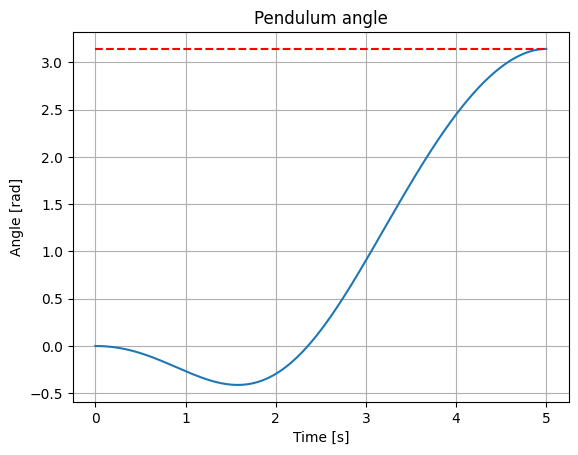

In [20]:
from matplotlib import pyplot as plt

timeseries = cs.linspace(0, T, N)

plt.title("Pendulum angle")
plt.grid()
plt.plot(timeseries, q)
plt.hlines(qfinal, 0, T, color="red", linestyle="dashed")
plt.xlabel("Time [s]")
plt.ylabel("Angle [rad]")

Text(0, 0.5, 'Velocity [rad/s]')

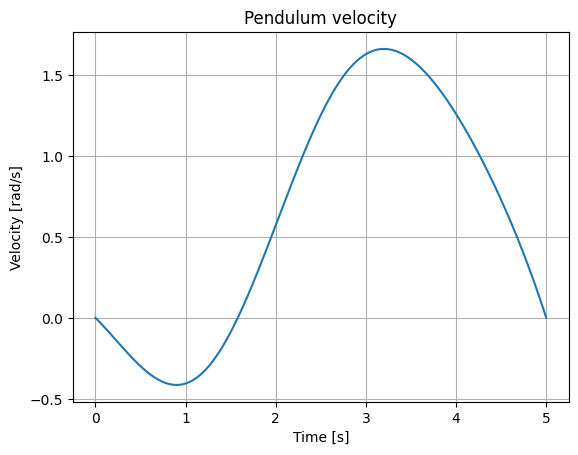

In [21]:
from matplotlib import pyplot as plt

timeseries = cs.linspace(0, T, N)

plt.title("Pendulum velocity")
plt.grid()
plt.plot(timeseries, dq)
plt.xlabel("Time [s]")
plt.ylabel("Velocity [rad/s]")

Text(0, 0.5, 'Acceleration [rad/s^2]')

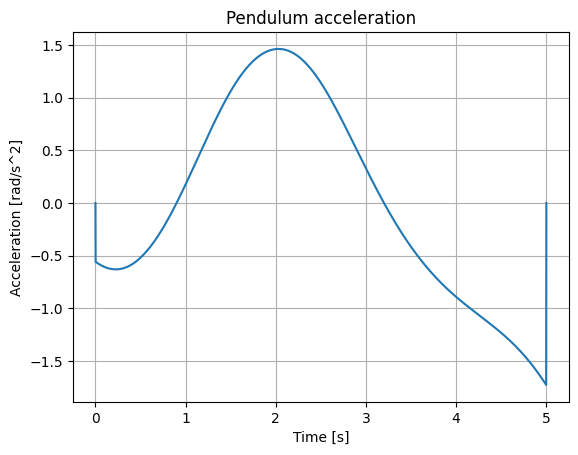

In [22]:
from matplotlib import pyplot as plt

timeseries = cs.linspace(0, T, N)

plt.title("Pendulum acceleration")
plt.grid()
plt.plot(timeseries, ddq)
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [rad/s^2]")

Text(0.5, 0, 'Time [s]')

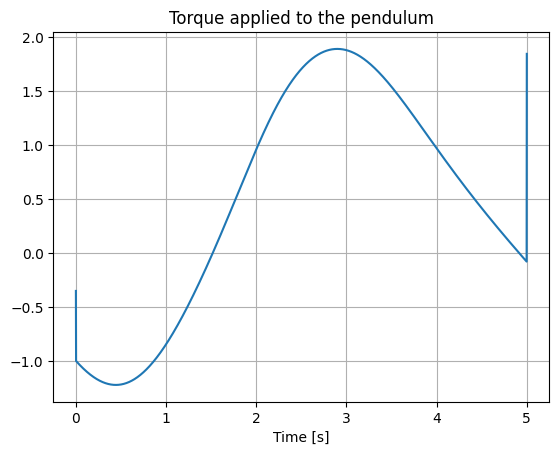

In [23]:
# compute what is the torque applied to the pendulum

from matplotlib import pyplot as plt

tau = []
for i in range(N):
    u = casadi_model([q[i], dq[i], ddq[i]])
    tau.append(u)

tau = np.array(tau).flatten()

timeseries = cs.linspace(0, T, N)

plt.title("Torque applied to the pendulum")
plt.grid()
plt.plot(timeseries, tau)
# plt.hlines([params["u_max"], -params["u_max"]], 0, T, linestyles="dashed", colors="red")
plt.xlabel("Time [s]")

## Evaluate overall performance

We have found trajectory but have to evaluate it in forward dynamics simulation

In [24]:
import pinocchio as pin

In [25]:
pin_model = pin.buildModelFromUrdf("../../robot_models/pendulum/pendulum.urdf")

pin_data = pin_model.createData()

In [26]:
q

array([ 0.00000000e+00, -1.71021168e-45, -2.23476330e-06, ...,
        3.14158574e+00,  3.14159265e+00,  3.14159265e+00])

In [28]:
q0, dq0 = q[0], dq[0]
tau0 = tau[0]

integrated_q = [q0]
integrated_dq = [dq0]

for i in range(N):
    ddq = pin.aba(
        pin_model,
        pin_data,
        np.array([q[i]]),
        np.array([dq[i]]),
        np.array([tau[i]]),
    )

    q_next = q[i] + dt * dq[i]
    dq_next = dq[i] + dt * ddq[0]

    integrated_q.append(q_next)
    integrated_dq.append(dq_next)

integrated_q = np.array(integrated_q)
integrated_dq = np.array(integrated_dq)

In [39]:
dt

0.002

# Comparison:

Below we can see the results of pendulum integration

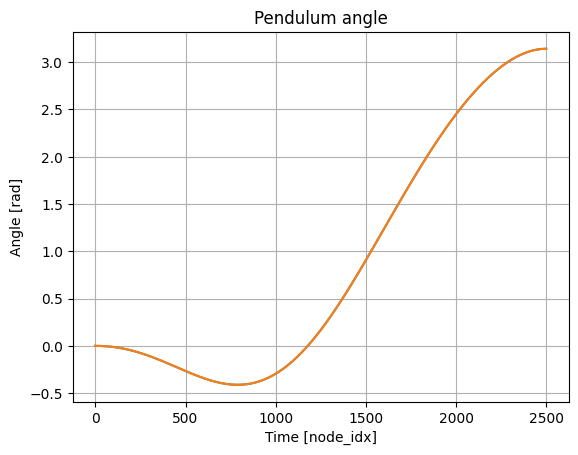

Text(0.5, 1.0, 'Pendulum angle error')

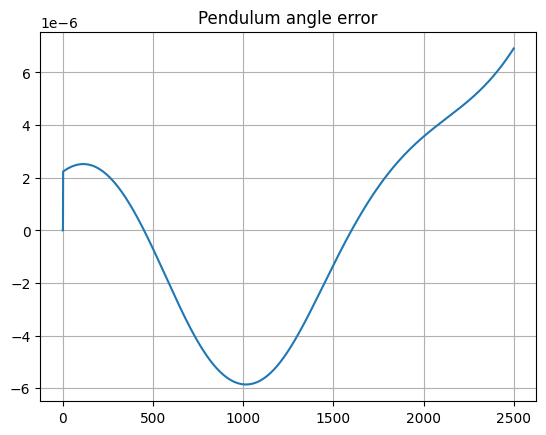

In [35]:
plt.figure()
plt.plot(integrated_q)
plt.plot(q)
plt.grid()
plt.title("Pendulum angle")
plt.xlabel("Time [node_idx]")
plt.ylabel("Angle [rad]")
plt.show()

plt.figure()
plt.plot(integrated_q[:-1] - q)
plt.grid()
plt.title("Pendulum angle error")

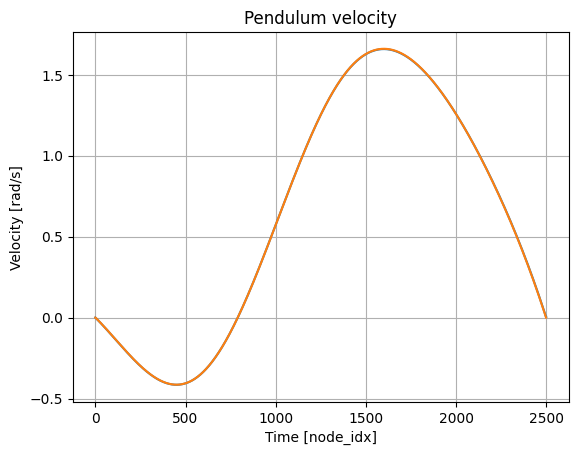

Text(0.5, 1.0, 'Pendulum velocity error')

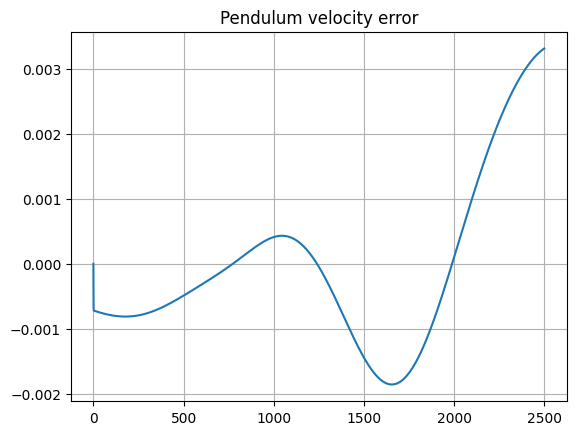

In [36]:
plt.figure()
plt.plot(integrated_dq)
plt.plot(dq)
plt.grid()
plt.title("Pendulum velocity")
plt.xlabel("Time [node_idx]")
plt.ylabel("Velocity [rad/s]")
plt.show()

plt.figure()
plt.plot(integrated_dq[:-1] - dq)
plt.grid()
plt.title("Pendulum velocity error")